# 1. Data cleaning

In [31]:
import pandas as pd  # Import pandas for data manipulation using dataframes
import numpy as np   # Import numpy for numerical operations and calculations

# Attempt to load the dataset from a CSV file.
# This block tries to open the file 'sensordata.csv' which should be located in the script's running directory or a specified path.
try:
    data = pd.read_csv('sensordata.csv')  # Load the data using pandas' read_csv function
    print("File loaded successfully.")   # Print success message if file loads without issues
except Exception as e:
    print(f"Error loading file: {e}")    # Print an error message if the file cannot be loaded, displaying the exception

# Check for and fill missing values in the dataset
# 'voc' column is checked for missing values which are then filled with the median of the column.
# Filling with the median (as opposed to mean) is more robust to outliers.
data['voc'].fillna(data['voc'].median(), inplace=True)

# Remove duplicate rows from the dataset
# Duplicates might skew or duplicate analysis results, so they are removed to ensure data quality.
data.drop_duplicates(inplace=True)

# Define columns to check for outliers
# These columns represent sensor readings and other measurements where extreme values may indicate sensor errors or anomalies.
cols = ['humidity', 'temperature', 'pressure', 'voc', 'pm2.5_alt',
        '0.3_um_count', '0.5_um_count', '1.0_um_count', '2.5_um_count', 
        '5.0_um_count', '10.0_um_count']

# Remove rows where any sensor reading exceeds 3 standard deviations from the mean
# This is a method of identifying and removing outliers which are statistically rare and may represent errors.
# Using standard deviation helps in finding outlying data points that differ significantly from the average distribution.
data_cleaned = data[(np.abs(data[cols] - data[cols].mean()) <= (3 * data[cols].std())).all(axis=1)]

# Save the cleaned data to a new CSV file if needed
# This step is crucial for documenting the cleaned dataset and using it in subsequent analysis without repeating cleaning steps.
try:
    data_cleaned.to_csv('sensorcleaned.csv', index=False)  # Save the cleaned data as 'sensorcleaned.csv' without the index
    print("File saved successfully.")  # Print success message if the file is saved without issues
except Exception as e:
    print(f"Error saving file: {e}")  # Print an error message if there is an issue saving the file, displaying the exception

# Display the first few rows of the cleaned data to confirm the changes
# This step is useful for a quick check to ensure that the cleaning process has been performed as expected.
print(data_cleaned.head())

File loaded successfully.
File saved successfully.
   time_stamp  humidity  temperature  pressure     voc  pm2.5_alt  \
0  1716958200      35.6       103.80   974.548  75.488       40.6   
1  1712625600      59.0        89.25   975.540  94.300       24.9   
2  1712636400      44.4       100.20   973.482  88.790       38.6   
3  1712214600      43.6       100.80   971.152  72.978        4.1   
4  1712213400      42.6       101.20   971.124  83.036        5.6   

   0.3_um_count  0.5_um_count  1.0_um_count  2.5_um_count  5.0_um_count  \
0          40.6     8654.3520      2552.037       402.651       31.4750   
1          24.9     5019.9975      1470.028       267.220       25.4115   
2          38.6     7882.2940      2315.513       404.434       36.0690   
3           4.1     1050.6190       298.393        33.164        2.6890   
4           5.6     1372.1910       393.363        51.584        6.1850   

   10.0_um_count  
0          5.909  
1          4.956  
2          7.345  
3      

/var/folders/qk/rt_g30ms5s3bymmrgcnhhcvr0000gn/T/ipykernel_7635/2360559752.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['voc'].fillna(data['voc'].median(), inplace=True)


# 2. Analysis

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Load the dataset from a CSV file.
# 'sensorcleaned.csv' is the file name, make sure it's in the same directory as the script or provide the full path.
data = pd.read_csv('sensorcleaned.csv')


Showing the Distribution and Spread of PM2.5

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/qk/rt_g30ms5s3bymmrgcnhhcvr0000gn/T/ipykernel_7635/2109741370.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data["pm2.5_alt"],palette="Set2")


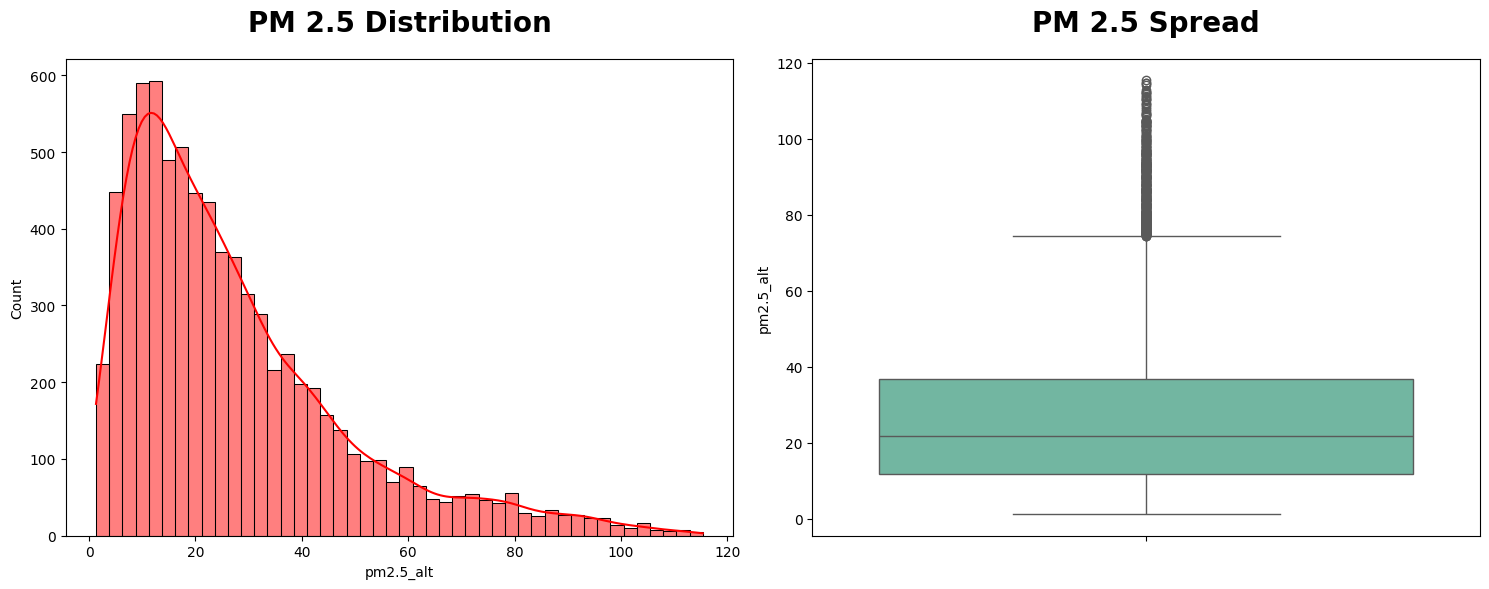

In [34]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(data["pm2.5_alt"], color="red", kde=True)
plt.title("PM 2.5 Distribution",fontweight="black",pad=20,fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(y=data["pm2.5_alt"],palette="Set2")
plt.title("PM 2.5 Spread",fontweight="black",pad=20,fontsize=20)
plt.tight_layout()
plt.show()

Looking for Outliers

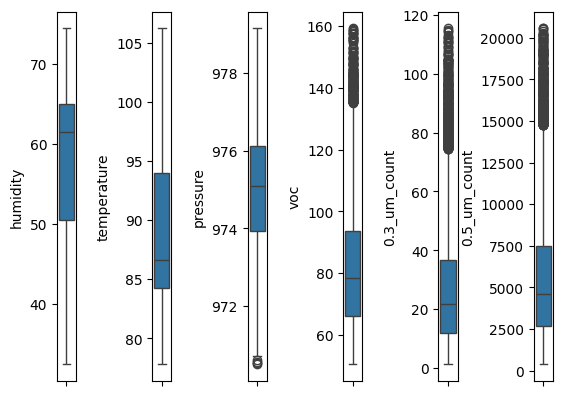

In [35]:
humidities = data['humidity']
temperatures = data['temperature']
pressures = data['pressure']
vocs = data['voc']
first_um_count = data['0.3_um_count']
second_um_count = data['0.5_um_count']
third_um_count = data['1.0_um_count']
fourth_um_count= data['2.5_um_count']
fifth_um_count = data['5.0_um_count']
sixth_um_count= data['10.0_um_count']

fig, axes = plt.subplots(1,6)
plt.subplots_adjust(wspace=4)
sns.boxplot(y=humidities, ax=axes[0])
sns.boxplot(y=temperatures, ax=axes[1])
sns.boxplot(y=pressures, ax=axes[2])
sns.boxplot(y=vocs, ax=axes[3])
sns.boxplot(y=first_um_count, ax=axes[4])
sns.boxplot(y=second_um_count, ax=axes[5])
plt.show()

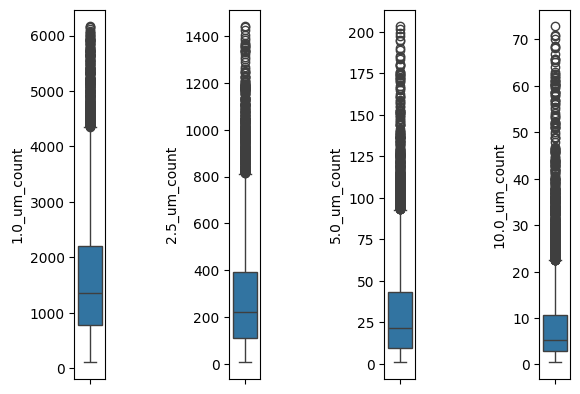

In [36]:
fig, axes = plt.subplots(1,4)
plt.subplots_adjust(wspace=4)
sns.boxplot(y=third_um_count, ax=axes[0])
sns.boxplot(y=fourth_um_count, ax=axes[1])
sns.boxplot(y=fifth_um_count, ax=axes[2])
sns.boxplot(y=sixth_um_count, ax=axes[3])
plt.show()

Showing Pair Plot

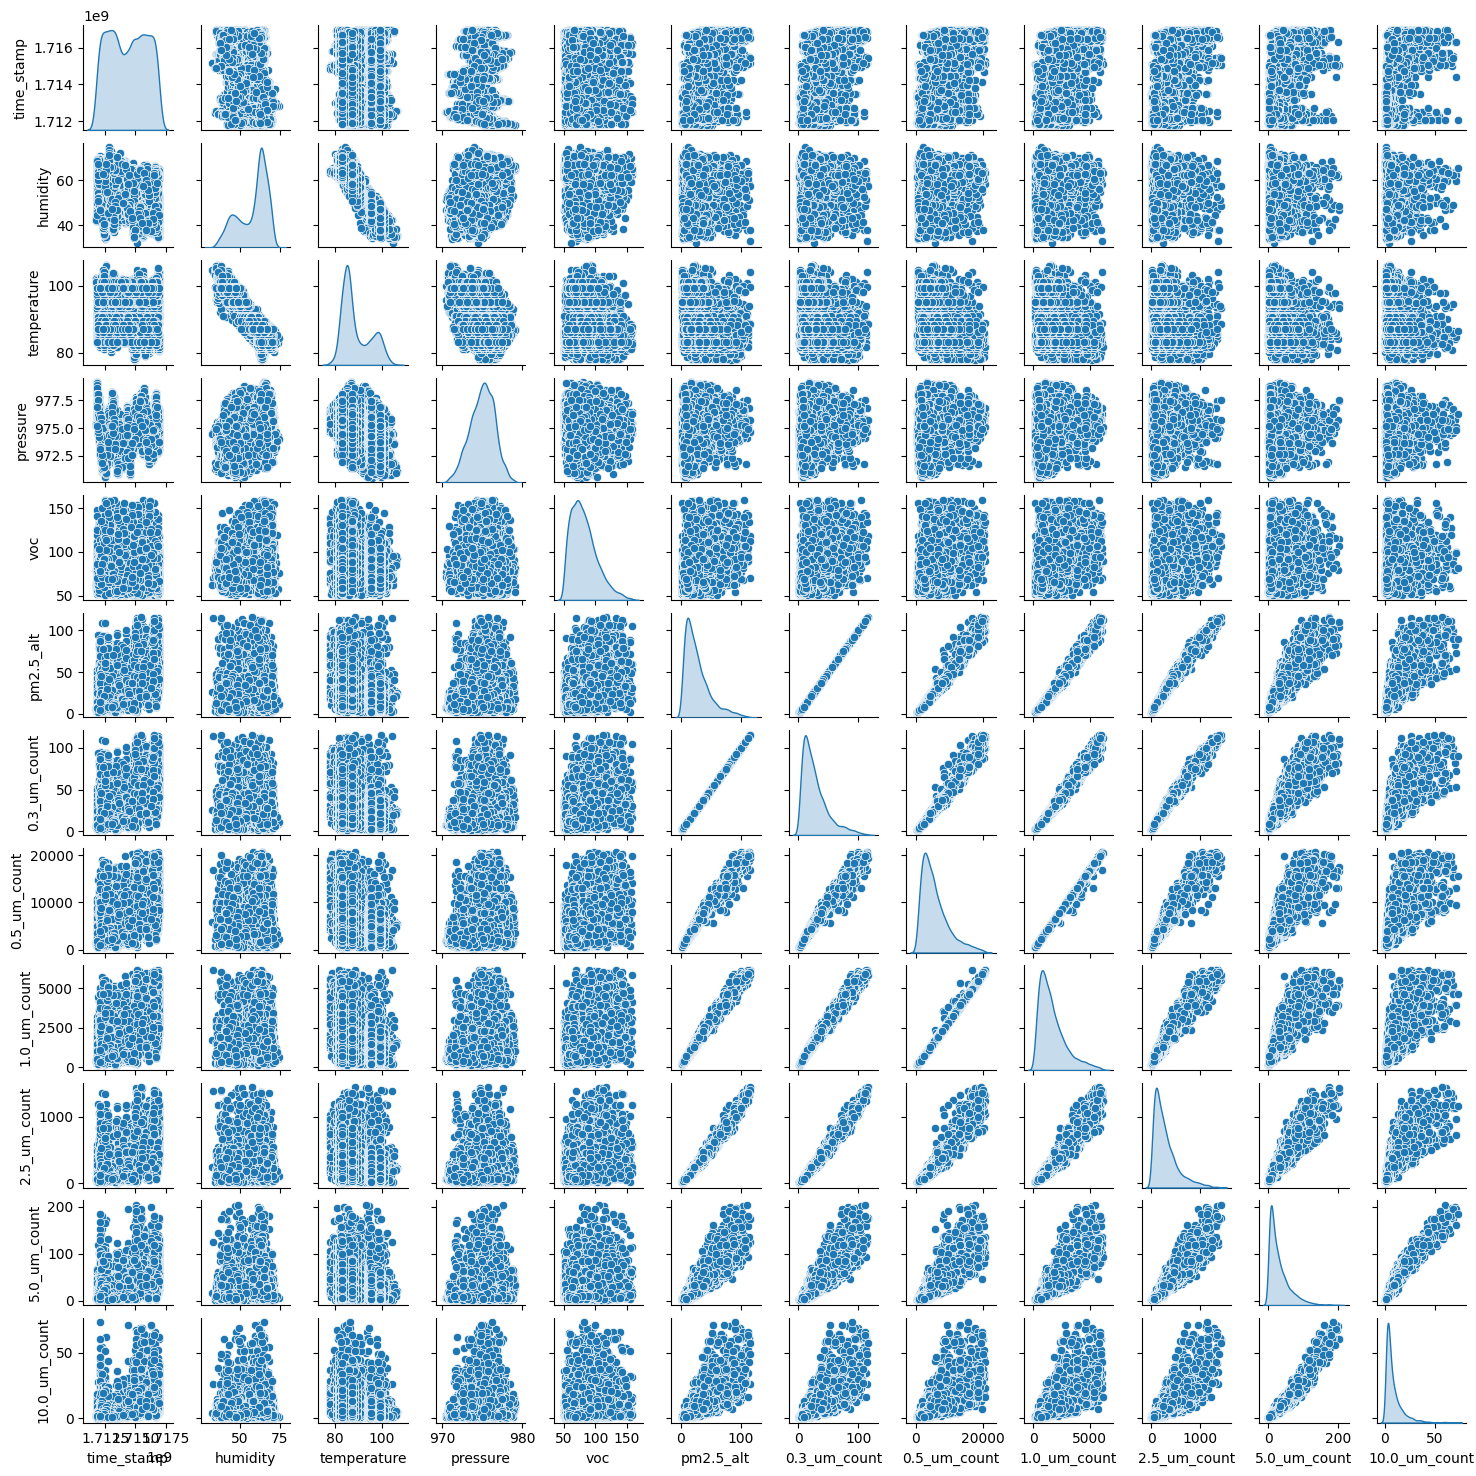

In [37]:
sns.pairplot(data, diag_kind='kde', height=1.25)
plt.show()

Showing Heatmap

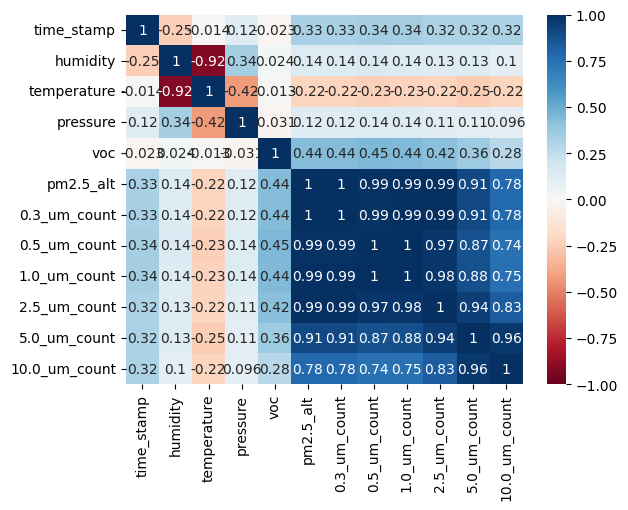

In [38]:
# bukan pakai X
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True)
plt.show()

In [39]:

# Select features and the target variable from the dataset.
# Features are all the columns that might influence the outcome (PM2.5 particle concentration in this case).
# The target is what we are trying to predict, here it's 'pm2.5_alt', representing PM2.5 levels.
X = data[['humidity', 'temperature', 'pressure', 'voc', '0.3_um_count', '0.5_um_count', '1.0_um_count', '2.5_um_count', '5.0_um_count', '10.0_um_count']]
y = data['pm2.5_alt']

# Split the dataset into training and testing sets to validate the model performance later.
# 80% of the data is used for training and 20% for testing.
# Random state is set for reproducibility, ensuring the same split occurs every time the script runs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:

# Normalize the feature data using StandardScaler, which removes the mean and scales to unit variance.
# This step improves the performance of many machine learning models.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit to data, then transform it.
X_test_scaled = scaler.transform(X_test)        # Apply same transformation to test data without fitting.

model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV for hyperparameter tuning.
# This will search over specified parameter values for the estimator.
# 'n_estimators', 'max_depth', and 'min_samples_split' are parameters of the RandomForest model we are tuning.
# GridSearchCV will use cross-validation (cv=3) to evaluate each combination of parameters.
param_grid = {
    'n_estimators': [50, 100, 150],     # Number of trees in the forest.
    'max_depth': [10, 20, 30],          # Maximum depth of the tree.
    'min_samples_split': [2, 5, 10]     # Minimum number of samples required to split an internal node.
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)  # Run grid search to find the best parameters.

# Output the best parameters found by GridSearchCV.
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=   2.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=   2.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=   2.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_split=5, n_e

In [41]:
# Use the best model to make predictions on the test set.
y_pred = best_model.predict(X_test_scaled)

In [42]:

# Evaluate the model performance.
# RMSE (Root Mean Squared Error) provides an indication of how much error in prediction exists.
# R2 Score provides an indication of goodness of fit and should be as close to 1 as possible in a good model.
rmse = sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
r2 = r2_score(y_test, y_pred)                    # Calculate R2 score
print("RMSE:", rmse)
print("R2 Score:", r2)

RMSE: 0.04741342345520828
R2 Score: 0.9999952142470777
